In [1]:
# 调用相关库
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import DataFrame
from pandas import concat
from scipy.io import savemat,loadmat
import numpy
import os

In [2]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
dataset = pd.read_excel("816480.xlsx")
fratures_Corrected_irradiance = [
    'Flow (Veh/5 Minutes)'
]
values = dataset[fratures_Corrected_irradiance].values
n_features=1 #特征数量

In [4]:
# 标准化
scaler =StandardScaler()
scaled = scaler.fit_transform(values)

In [5]:
n_in = 3
n_out = 1
# 构造一个20->1的监督学习型数据
reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
values=reframed.values

In [6]:
#训练集和测试集的划分比例
ratio=0.8 
N=int(len(values) *ratio)
train = values[:N, :]
test = values[N:, :]

# 划分输入和输出,split into input and outputs
n_obs = n_in *  n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]

# 将数据转换为3D输入，[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_in, n_features))
test_X = test_X.reshape((test_X.shape[0], n_in, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1149, 3, 1) (1149, 1) (288, 3, 1) (288, 1)


In [7]:
def dblstm():
#建立模型
    inputs=Input(shape=(train_X.shape[1], train_X.shape[2]))
    bilstm=Bidirectional(LSTM(128, activation='selu',return_sequences=True))(inputs)
    bilstm=Bidirectional(LSTM(64, activation='selu',return_sequences=True))(bilstm)
    bilstm=Bidirectional(LSTM(32, activation='selu',return_sequences=True))(bilstm)
    bilstm=Bidirectional(LSTM(16, activation='selu',return_sequences=False))(bilstm)
    outputs = Dense(1)(bilstm)
    model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),loss='mse')
    model.compile(loss='mse',optimizer='Adam')
    model.summary()#展示模型结构
    return model

model = dblstm()#建立模型
history = model.fit(train_X, train_y, epochs=60, batch_size=30,validation_data=(test_X, test_y),verbose=2,
                    shuffle=False)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 3, 256)           133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 128)           164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 3, 64)            41216     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               10368     
 nal)                                                        

In [8]:
#预测
yhat= model.predict(test_X)
# 对预测结果进行反归一化
inv_yhat = scaler.inverse_transform(yhat)
# 将真实列据进行反归一化
inv_y = scaler.inverse_transform(test_y)

In [9]:
# 计算RMSE
def mape(y_true, y_pred):
    #评价指标MAPE
    record=[]
    for index in range(len(y_true)):
        if abs(y_true[index])>10:
            temp_mape=np.abs((y_pred[index] - y_true[index]) / y_true[index])
            record.append(temp_mape)
    return np.mean(record) * 100
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(inv_y, inv_yhat))
print('Test MAPE: %.7f' % mape(inv_y, inv_yhat))
print('Test R2: %.7f' % r2_score(inv_y, inv_yhat))

Test RMSE: 34.8750529
Test MAE: 27.8610540
Test MAPE: 11.6953573
Test R2: 0.9543324


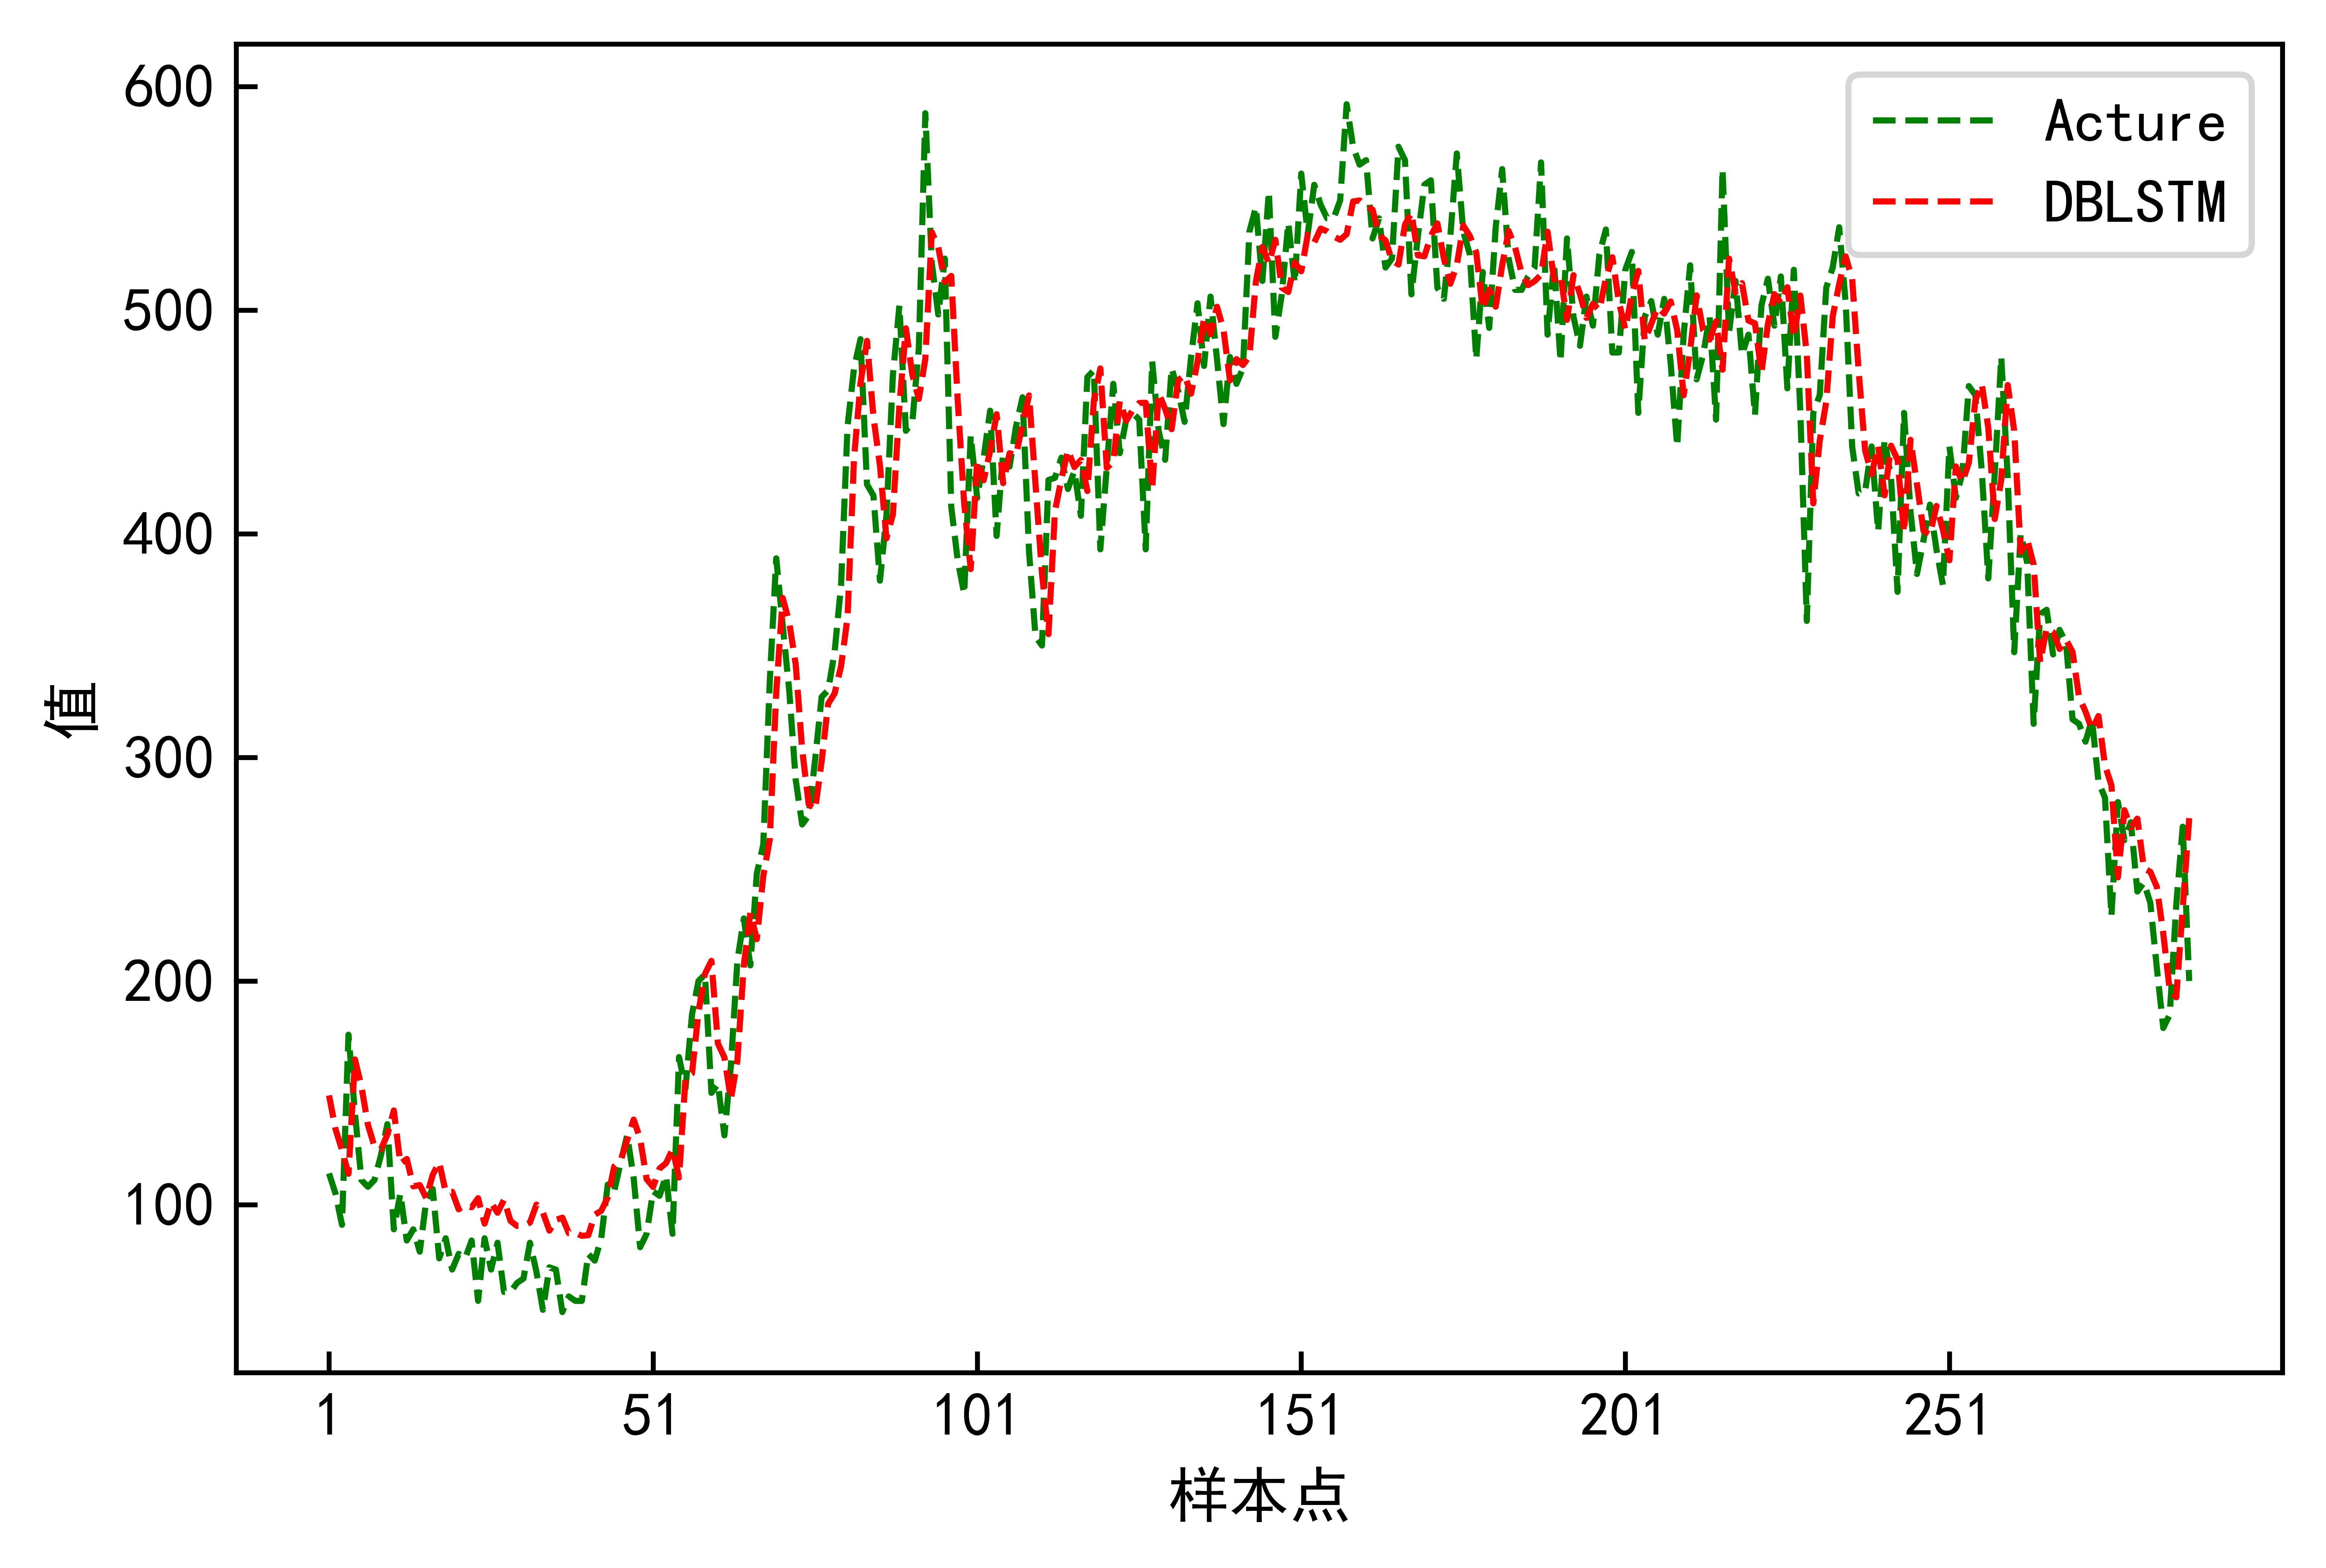

In [10]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(inv_yhat)+1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, inv_y, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, inv_yhat, color='red',linestyle="--",linewidth=1,label='DBLSTM')
# plt.plot(x, inv_y,color='g',linewidth=1, label='真实值')
# plt.plot(x, inv_yhat,color='red',linestyle="--",linewidth=1,label='预测值')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("值",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('figure/LSTM预测结果图.png')
plt.show()

In [11]:
#保存预测结果
savemat('结果/dblstm_result.mat',{'true':inv_y,'pred':inv_yhat})